In [2]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff

In [3]:
csvtest="H:\\PHD_data\\Imaging_et_analysis\\Sp8Imaging\\2023\\03_Mar\\28032023_K4K8MosaicGood\\Pos001_goodlateral\\TackedMasksSpots.csv"
data = pd.read_csv(csvtest)
data.columns

Index(['LABEL', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_SPOT_COLOR', 'MEAN_INTENSITY_CH1', 'MEDIAN_INTENSITY_CH1',
       'MIN_INTENSITY_CH1', 'MAX_INTENSITY_CH1', 'TOTAL_INTENSITY_CH1',
       'STD_INTENSITY_CH1', 'MEAN_INTENSITY_CH2', 'MEDIAN_INTENSITY_CH2',
       'MIN_INTENSITY_CH2', 'MAX_INTENSITY_CH2', 'TOTAL_INTENSITY_CH2',
       'STD_INTENSITY_CH2', 'MEAN_INTENSITY_CH3', 'MEDIAN_INTENSITY_CH3',
       'MIN_INTENSITY_CH3', 'MAX_INTENSITY_CH3', 'TOTAL_INTENSITY_CH3',
       'STD_INTENSITY_CH3', 'CONTRAST_CH1', 'SNR_CH1', 'CONTRAST_CH2',
       'SNR_CH2', 'CONTRAST_CH3', 'SNR_CH3', 'ELLIPSE_X0', 'ELLIPSE_Y0',
       'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
       'SHAPE_INDEX'],
      dtype='object')

In [4]:
# Setup columns (using your provided column names)
time_col = 'POSITION_T'
intensity_col = 'MEAN_INTENSITY_CH1'
area_col = 'AREA'
id_col = 'ID' if 'ID' in data.columns else ('LABEL' if 'LABEL' in data.columns else None)
# Ensure time and numeric columns are numeric
data[time_col] = pd.to_numeric(data[time_col], errors='coerce')
data[intensity_col] = pd.to_numeric(data[intensity_col], errors='coerce')
data[area_col] = pd.to_numeric(data[area_col], errors='coerce')
# Drop rows missing critical values
data = data.dropna(subset=[intensity_col, area_col])
# Binning: choose number of bins
n_bins = 5
# Fixed-width bins (useful when absolute intensity thresholds matter)
fixed_bins = np.linspace(data[intensity_col].min(), data[intensity_col].max(), n_bins+1)
data['intensity_bin_fixed'] = pd.cut(data[intensity_col], bins=fixed_bins, include_lowest=True)
# Quantile bins (equal-count groups)
# duplicates='drop' handles many identical intensity values
data['intensity_bin_quantile'] = pd.qcut(data[intensity_col], q=n_bins, labels=[f'Q{i+1}' for i in range(n_bins)], duplicates='drop')
# Quick check of bins
print('Intensity range:', data[intensity_col].min(), '->', data[intensity_col].max())
print(data[[intensity_col, 'intensity_bin_fixed', 'intensity_bin_quantile']].head())

Intensity range: 5.932475884244373 -> 355.039764359352
   MEAN_INTENSITY_CH1 intensity_bin_fixed intensity_bin_quantile
3           62.712500     (5.931, 75.754]                     Q2
4           61.774373     (5.931, 75.754]                     Q2
5           41.672727     (5.931, 75.754]                     Q1
6           46.974684     (5.931, 75.754]                     Q1
7           55.955774     (5.931, 75.754]                     Q1


In [ ]:
time="POSITION_T"
intensity_col = ['MEAN_INTENSITY_CH1','MEAN_INTENSITY_CH2']

In [9]:
id_col = 'ID' if 'ID' in data.columns else ('LABEL' if 'LABEL' in data.columns else None)
area_col = 'AREA'
# Ensure time and numeric columns are numeric
data[time] = pd.to_numeric(data[time], errors='coerce')
for col in intensity_col:   
    data[col] = pd.to_numeric(data[col], errors='coerce')
data[area_col] = pd.to_numeric(data[area_col], errors='coerce')

In [10]:
group_cols=[id_col]
pivot_area = data.pivot_table(index='POSITION_T', columns=id_col, values='AREA')
pivot_ch2  = data.pivot_table(index='POSITION_T', columns=id_col, values='MEAN_INTENSITY_CH1')
# example: mean across spots at each time (equivalent to the aggregated method above)
mean_area_across_spots = pivot_area.mean(axis=1).sort_index()
mean_ch2_across_spots = pivot_ch2.mean(axis=1).sort_index()

In [14]:
data.head()

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY,SHAPE_INDEX,intensity_bin_fixed,intensity_bin_quantile
3,ID9728,9728,0,159.0,302.6873945373659,16.735917332852356,0.0,6.0,6,8.64522868272742,...,5.923668152814357,2.9232399801150315,2.322042704327067,234.802569,68.75191643235674,0.6242277785537754,0.9166666666666664,4.48676565115964,"(5.931, 75.754]",Q2
4,ID9984,9984,0,356.0,295.5246730473158,18.975166320414072,0.0,9.0,9,12.95202444171643,...,10.698175865288437,-0.041985560965613976,1.5507296150184886,527.017678,89.22048832853596,0.8319665309273682,0.9848693259972491,3.886440330661803,"(5.931, 75.754]",Q2
5,ID9378,9378,0,108.0,308.624385112057,16.649282658579068,0.0,4.0,4,7.163136078730068,...,5.7928279792655655,-0.12564005053114485,1.8605607006318405,161.196748,53.5801174954973,0.7056003971723506,0.9776785714285714,4.220127028716694,"(5.931, 75.754]",Q1
6,ID11426,11426,0,238.0,275.4153691057467,15.557960949448734,0.0,14.0,14,10.52717189646848,...,7.2786848820476795,3.1313649365550247,2.336081903044081,348.155533,84.47237003560092,0.6131317516640662,0.9366336633663366,4.527182774289597,"(5.931, 75.754]",Q1
7,ID10626,10626,0,409.0,271.9638197688709,15.587202837969603,0.0,18.0,18,13.801504041887643,...,10.100194878896458,3.0831294042468427,1.9733269246339027,598.415324,102.97690339690185,0.7091415208543665,0.9531066822977727,4.209577163924043,"(5.931, 75.754]",Q1


In [15]:
data.pivot_table(index="TRACK_ID",columns="POSITION_T",values="AREA")
data.pivot_table(index="TRACK_ID",columns="POSITION_T",values="MEAN_INTENSITY_CH1")

POSITION_T,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
TRACK_ID,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,51.592784,41.672727,53.606061,62.712500,65.251908,63.842105,61.774373,58.567723,58.743151,55.870036,50.107884,46.974684,48.235556,45.778195,53.847134,55.955774,51.508299
1,NaN,NaN,NaN,47.573840,52.412698,61.096154,62.110465,73.928571,68.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,55.490463,21.717647,15.586207,43.201493,42.762557,44.901408,42.164179,46.224615,44.432234,42.040541,40.546012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,87.619231,86.677796,79.429799,88.205128,89.724891,88.443609,91.291139,90.091503,98.279035,102.826087,100.316754,100.993857,101.764072,104.281642,100.273230,100.742739,92.340648,92.447791,106.775105,107.844324
101,31.252632,68.729614,100.017094,90.730310,87.748780,131.815421,92.811765,97.221190,99.267516,104.893354,109.001484,113.220979,106.127223,101.465608,106.500000,99.939832,96.304751,94.972558,92.821888,92.737448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,84.619318,89.548872,73.068894,73.943038,77.898361,82.984127,84.037037,90.912791,86.068796,93.257683,94.306998,92.552106,93.732673,91.667984,87.637736,87.608392,93.796167,109.159247,110.085246,107.440262
96,87.497992,91.099237,98.910345,90.676667,84.615819,90.070886,91.127389,88.892929,97.250447,90.598673,87.043411,86.912607,85.686546,85.546543,92.969773,101.534198,100.618664,97.900943,91.070588,88.163290
97,49.357955,57.624615,38.500000,58.567568,50.222826,51.357513,61.456000,65.622324,139.737430,133.349614,159.321429,149.270023,152.802222,186.526639,181.580851,192.949343,201.953405,198.157895,189.416816,191.101786


In [16]:
data.head(5)

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY,SHAPE_INDEX,intensity_bin_fixed,intensity_bin_quantile
3,ID9728,9728,0,159.0,302.6873945373659,16.735917332852356,0.0,6.0,6,8.64522868272742,...,5.923668152814357,2.9232399801150315,2.322042704327067,234.802569,68.75191643235674,0.6242277785537754,0.9166666666666664,4.48676565115964,"(5.931, 75.754]",Q2
4,ID9984,9984,0,356.0,295.5246730473158,18.975166320414072,0.0,9.0,9,12.95202444171643,...,10.698175865288437,-0.041985560965613976,1.5507296150184886,527.017678,89.22048832853596,0.8319665309273682,0.9848693259972491,3.886440330661803,"(5.931, 75.754]",Q2
5,ID9378,9378,0,108.0,308.624385112057,16.649282658579068,0.0,4.0,4,7.163136078730068,...,5.7928279792655655,-0.12564005053114485,1.8605607006318405,161.196748,53.5801174954973,0.7056003971723506,0.9776785714285714,4.220127028716694,"(5.931, 75.754]",Q1
6,ID11426,11426,0,238.0,275.4153691057467,15.557960949448734,0.0,14.0,14,10.52717189646848,...,7.2786848820476795,3.1313649365550247,2.336081903044081,348.155533,84.47237003560092,0.6131317516640662,0.9366336633663366,4.527182774289597,"(5.931, 75.754]",Q1
7,ID10626,10626,0,409.0,271.9638197688709,15.587202837969603,0.0,18.0,18,13.801504041887643,...,10.100194878896458,3.0831294042468427,1.9733269246339027,598.415324,102.97690339690185,0.7091415208543665,0.9531066822977727,4.209577163924043,"(5.931, 75.754]",Q1


Plot mean area over time for tracks whose channel-1 intensity at the first timepoint is above vs below the mean. The code creates pivot tables if needed, computes group means and SEM, and draws lines with shaded error bands.

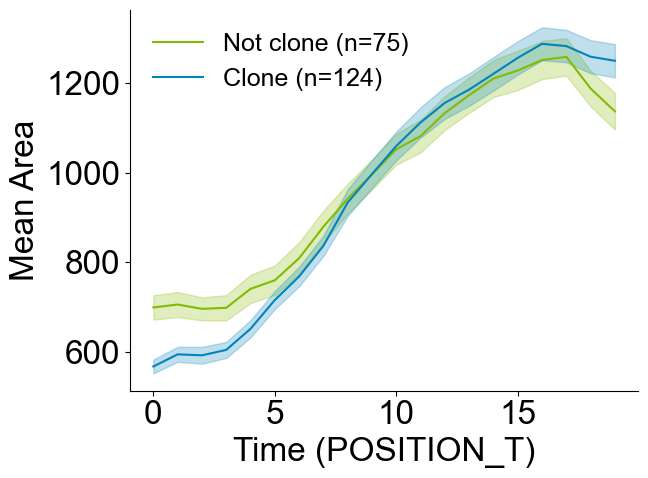

{'mean_above': POSITION_T
 0.0      699.098273
 1.0      705.595214
 2.0      695.977387
 3.0      698.273888
 4.0      740.617681
 5.0      759.734749
 6.0      809.111987
 7.0      879.351119
 8.0      941.920839
 9.0      995.827398
 10.0    1052.373289
 11.0    1081.768130
 12.0    1133.252113
 13.0    1173.144054
 14.0    1210.236562
 15.0    1228.203622
 16.0    1251.433900
 17.0    1258.659539
 18.0    1187.850739
 19.0    1136.964581
 dtype: float64,
 'sem_above': POSITION_T
 0.0     27.109707
 1.0     27.962525
 2.0     25.701362
 3.0     28.231129
 4.0     31.637648
 5.0     33.094091
 6.0     35.624954
 7.0     35.973246
 8.0     33.350221
 9.0     33.345487
 10.0    34.608468
 11.0    36.546729
 12.0    37.785849
 13.0    39.633767
 14.0    41.328952
 15.0    44.021648
 16.0    42.575341
 17.0    42.148772
 18.0    39.744736
 19.0    40.871270
 dtype: float64,
 'mean_below': POSITION_T
 0.0      567.281249
 1.0      594.438236
 2.0      592.209695
 3.0      604.333470
 4.0 

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create pivots (safe to recreate even if they exist)
area_pivot = data.pivot_table(index='TRACK_ID', columns='POSITION_T', values='AREA')
int1_pivot = data.pivot_table(index='TRACK_ID', columns='POSITION_T', values='MEAN_INTENSITY_CH1')
int2_pivot=data.pivot_table(index='TRACK_ID', columns='POSITION_T', values='MEAN_INTENSITY_CH2')
int_pivot=int2_pivot
# Determine first timepoint column (try numeric conversion)
col_numeric = pd.to_numeric(int2_pivot.columns, errors='coerce')
if col_numeric.isnull().all():
    first_col = int2_pivot.columns[0]
else:
    first_time = col_numeric.min()
    first_col = int2_pivot.columns[(col_numeric == first_time)][0]

# Intensities at first timepoint and threshold
int_first = int2_pivot[first_col].dropna()
if int_first.empty:
    raise ValueError('No intensity values found at the first timepoint.')
threshold = int_first.mean()

# Split TRACK_IDs into above and below groups
above_ids = int_first[int_first > threshold].index.tolist()
below_ids = int_first[int_first <= threshold].index.tolist()

def group_stats(pivot, ids):
    if len(ids) == 0:
        return pd.Series(dtype=float), pd.Series(dtype=float)
    grp = pivot.loc[pivot.index.intersection(ids)]
    mean = grp.mean(axis=0, skipna=True)
    sem = grp.sem(axis=0, skipna=True)
    mean.index = pd.to_numeric(mean.index, errors='coerce')
    sem.index = pd.to_numeric(sem.index, errors='coerce')
    valid = ~mean.index.isna()
    mean = mean[valid].sort_index()
    sem = sem[valid].sort_index()
    return mean, sem

mean_above, sem_above = group_stats(area_pivot, above_ids)
mean_below, sem_below = group_stats(area_pivot, below_ids)

# Plotting
fig, ax = plt.subplots(figsize=(7, 5.3))
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams['font.size'] = 24
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
if not mean_above.empty:
    x = mean_above.index.values
    plt.plot(x, mean_above.values, label=f'Not clone (n={len(above_ids)})', color="#83bb03")
    plt.fill_between(x, (mean_above - sem_above).values, (mean_above + sem_above).values, color="#83bb03", alpha=0.25)
if not mean_below.empty:
    x = mean_below.index.values
    plt.plot(x, mean_below.values, label=f'Clone (n={len(below_ids)})', color="#0383bb")
    plt.fill_between(x, (mean_below - sem_below).values, (mean_below + sem_below).values, color="#0383bb", alpha=0.25)
plt.xlabel('Time (POSITION_T)')
plt.ylabel('Mean Area')

plt.legend(loc="upper left",frameon=False,fontsize=18)

plt.tight_layout()
output_folder=r"B:\home\PHD_data\Imaging_et_analysis\PaperFigures\FigureRev\MosaicKeratinMOAreaAnalysis"
plt.savefig(f"{output_folder}/MosaicKeratinMOAreaAnalysis.png", dpi=300, bbox_inches='tight',transparent=True)
plt.savefig(f"{output_folder}/MosaicKeratinMOAreaAnalysis.svg", dpi=300, bbox_inches='tight',transparent=True)
plt.savefig(f"{output_folder}/MosaicKeratinMOAreaAnalysis.pdf", dpi=300, bbox_inches='tight',transparent=True)

plt.show()

# Results available for further analysis
plot_results = {'mean_above': mean_above, 'sem_above': sem_above, 'mean_below': mean_below, 'sem_below': sem_below, 'threshold': threshold, 'first_col': first_col}
plot_results

<BarContainer object of 10 artists>

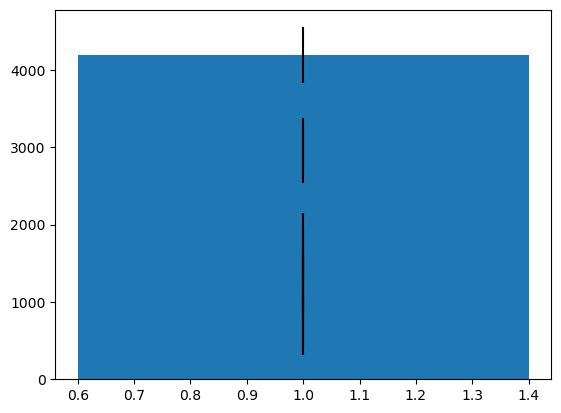

In [ ]:
viscosity=pd.read_csv(r"H:\PHD_data\Imaging_et_analysis\Stellaris\2025\13112025\ViscoResults_80umpip1311.csv")
plt.bar(1,viscosity["eta"],yerr=viscosity['eta'].std())

In [24]:
viscosity['eta'].std(),viscosity['eta'].mean()

(1138.256366170407, 1868.4453023544097)